In [86]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype, is_string_dtype
from sklearn.metrics import r2_score
import xgboost as xgb
plt.rcParams['figure.figsize'] = 16, 9

# Prepare dataset

In [10]:
df = pd.read_csv('./data/train.csv')

In [11]:
# Transform categorical data into numerical data
def make_cats(df):
    for n, c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype('category').cat.as_ordered()
            df[n] = df[n].cat.codes + 1
            
# If a column has missing values, replace them with the median and add another column 'missing'
def fix_numeric(df):
    for n in df:
        col = df[n]
        if is_numeric_dtype(col) and any(pd.isnull(col)):
            df[n + '_nan'] = pd.isnull(col) * 1
            filler = col.median()
            df[n] = col.fillna(filler)

In [12]:
df.drop('Id', axis='columns', inplace=True)
make_cats(df)
fix_numeric(df)

In [20]:
X = df.drop('SalePrice', axis='columns')
Y = df.SalePrice
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3)

In [21]:
len(X_train), len(X_valid), len(X_test)

(817, 351, 292)

# Random forest

In [77]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, Y_train)
print('Validation: ', r2_score(Y_valid, rf.predict(X_valid)))
print('Training: ', r2_score(Y_train, rf.predict(X_train)))

Validation:  0.767147865699559
Training:  0.8158940396277206


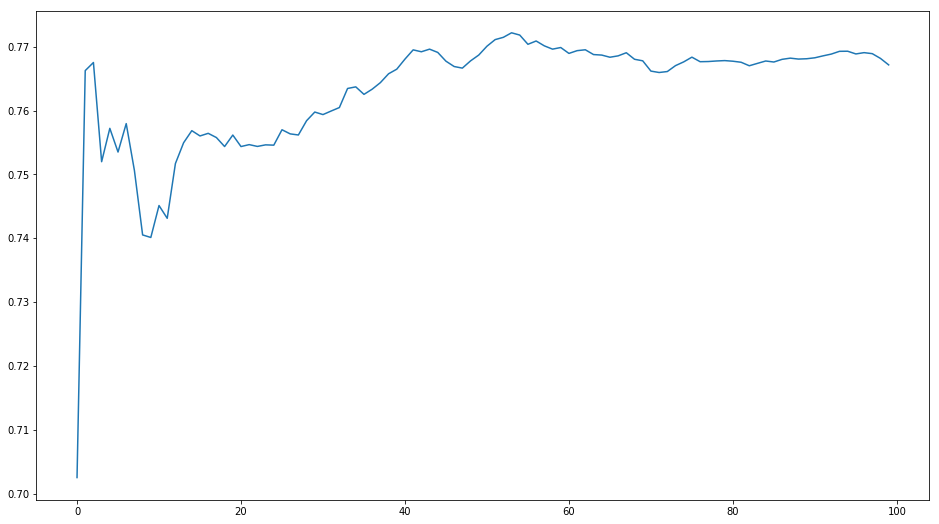

In [78]:
preds = np.stack([t.predict(X_valid) for t in rf.estimators_])
plt.plot([r2_score(Y_valid, np.mean(preds[:i+1], axis=0)) for i in range(100)])

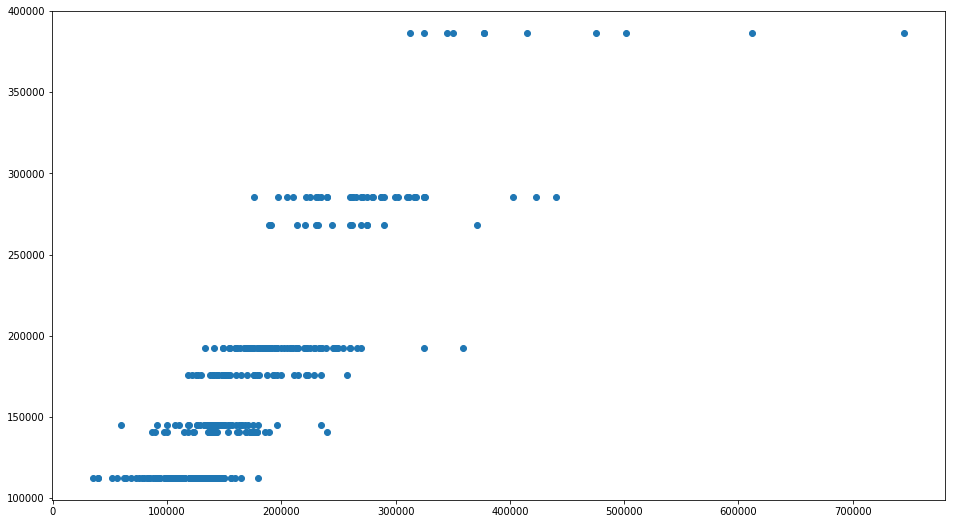

In [85]:
plt.scatter(Y_valid, np.mean(preds[:1], axis=0))

# Tuning

In [51]:
rf = RandomForestRegressor(n_estimators=128, n_jobs=-1, min_samples_leaf=3, max_depth=8, max_features=0.7)
rf.fit(X_train, Y_train)
print('Validation: ', r2_score(Y_valid, rf.predict(X_valid)))
print('Training: ', r2_score(Y_train, rf.predict(X_train)))

Validation:  0.8571209678586758
Training:  0.9506715695025579


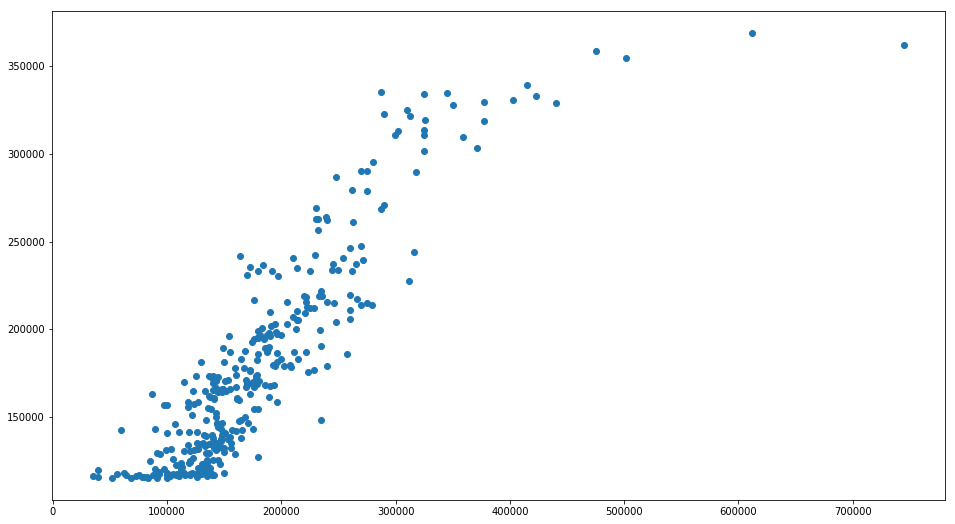

In [120]:
plt.scatter(Y_valid, rf.predict(X_valid))

# XGBoost
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## Learning rate and tree based parameters

In [117]:
xgb_params = {
    'learning_rate': 0.03,  # start high, go down when fine tuning
    'max_depth': 4,         # up to 10
    'min_child_weight': 2,  # this is similar to min_samples_leaf
    'gamma': 0.028,         # minimum reduction for doing a split (something like min_delta from EarlyStopping)
    'subsample': 0.6,
    'colsample_bylevel': 0.55,
    'reg_lambda': 1.1,
    'objective': 'reg:linear',
    'tree_method': 'exact',
    'n_estimators': 2500,
}
xgb_model = xgb.XGBRegressor(**xgb_params)

In [118]:
xgb_model.fit(X_train, Y_train,
          eval_set=[(X_valid, Y_valid)],
          early_stopping_rounds=200,
          eval_metric='rmse')

[0]	validation_0-rmse:191323
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:186160
[2]	validation_0-rmse:181042
[3]	validation_0-rmse:176299
[4]	validation_0-rmse:171708
[5]	validation_0-rmse:167089
[6]	validation_0-rmse:162592
[7]	validation_0-rmse:158187
[8]	validation_0-rmse:154014
[9]	validation_0-rmse:149908
[10]	validation_0-rmse:145989
[11]	validation_0-rmse:142232
[12]	validation_0-rmse:138393
[13]	validation_0-rmse:134812
[14]	validation_0-rmse:131295
[15]	validation_0-rmse:127841
[16]	validation_0-rmse:124398
[17]	validation_0-rmse:121273
[18]	validation_0-rmse:118292
[19]	validation_0-rmse:115278
[20]	validation_0-rmse:112378
[21]	validation_0-rmse:109604
[22]	validation_0-rmse:106859
[23]	validation_0-rmse:104231
[24]	validation_0-rmse:101655
[25]	validation_0-rmse:99185
[26]	validation_0-rmse:96839.1
[27]	validation_0-rmse:94592.5
[28]	validation_0-rmse:92375.3
[29]	validation_0-rmse:90231.2
[30]	validation_0-rmse:88154.7
[31]	valid

[260]	validation_0-rmse:31944.6
[261]	validation_0-rmse:31946.9
[262]	validation_0-rmse:31960.7
[263]	validation_0-rmse:31953.9
[264]	validation_0-rmse:31950.5
[265]	validation_0-rmse:31926
[266]	validation_0-rmse:31945.5
[267]	validation_0-rmse:31926.4
[268]	validation_0-rmse:31931.3
[269]	validation_0-rmse:31924.3
[270]	validation_0-rmse:31882.2
[271]	validation_0-rmse:31881.6
[272]	validation_0-rmse:31861.5
[273]	validation_0-rmse:31862.1
[274]	validation_0-rmse:31862.7
[275]	validation_0-rmse:31868.8
[276]	validation_0-rmse:31864.6
[277]	validation_0-rmse:31858.4
[278]	validation_0-rmse:31852.5
[279]	validation_0-rmse:31822.7
[280]	validation_0-rmse:31819.7
[281]	validation_0-rmse:31809.7
[282]	validation_0-rmse:31795.8
[283]	validation_0-rmse:31803
[284]	validation_0-rmse:31788.1
[285]	validation_0-rmse:31751
[286]	validation_0-rmse:31755.5
[287]	validation_0-rmse:31766.1
[288]	validation_0-rmse:31750.1
[289]	validation_0-rmse:31723.7
[290]	validation_0-rmse:31700
[291]	validation

[518]	validation_0-rmse:31257
[519]	validation_0-rmse:31257.4
[520]	validation_0-rmse:31257.8
[521]	validation_0-rmse:31253.9
[522]	validation_0-rmse:31258.3
[523]	validation_0-rmse:31260.1
[524]	validation_0-rmse:31257.1
[525]	validation_0-rmse:31253.6
[526]	validation_0-rmse:31246.9
[527]	validation_0-rmse:31262.6
[528]	validation_0-rmse:31261.7
[529]	validation_0-rmse:31266.3
[530]	validation_0-rmse:31265.1
[531]	validation_0-rmse:31267.4
[532]	validation_0-rmse:31264.5
[533]	validation_0-rmse:31250.2
[534]	validation_0-rmse:31255.6
[535]	validation_0-rmse:31251.7
[536]	validation_0-rmse:31249.9
[537]	validation_0-rmse:31247.6
[538]	validation_0-rmse:31257.4
[539]	validation_0-rmse:31255.4
[540]	validation_0-rmse:31251.1
[541]	validation_0-rmse:31248.5
[542]	validation_0-rmse:31250.8
[543]	validation_0-rmse:31245.4
[544]	validation_0-rmse:31244.1
[545]	validation_0-rmse:31244
[546]	validation_0-rmse:31242.8
[547]	validation_0-rmse:31242.9
[548]	validation_0-rmse:31241.4
[549]	valida

[776]	validation_0-rmse:31186.3
[777]	validation_0-rmse:31184.6
[778]	validation_0-rmse:31185.2
[779]	validation_0-rmse:31186.9
[780]	validation_0-rmse:31186.6
[781]	validation_0-rmse:31185
[782]	validation_0-rmse:31184.9
[783]	validation_0-rmse:31184.6
[784]	validation_0-rmse:31184.3
[785]	validation_0-rmse:31194.9
[786]	validation_0-rmse:31192.9
[787]	validation_0-rmse:31191.3
[788]	validation_0-rmse:31190.7
[789]	validation_0-rmse:31191.9
[790]	validation_0-rmse:31198.1
[791]	validation_0-rmse:31197
[792]	validation_0-rmse:31196
[793]	validation_0-rmse:31191
[794]	validation_0-rmse:31188.6
[795]	validation_0-rmse:31189.2
[796]	validation_0-rmse:31195.3
[797]	validation_0-rmse:31195.7
[798]	validation_0-rmse:31192.6
[799]	validation_0-rmse:31197.8
[800]	validation_0-rmse:31198.3
[801]	validation_0-rmse:31197.7
[802]	validation_0-rmse:31200
[803]	validation_0-rmse:31198.7
[804]	validation_0-rmse:31199.2
[805]	validation_0-rmse:31201.6
[806]	validation_0-rmse:31200.2
[807]	validation_0

[1033]	validation_0-rmse:31150.3
[1034]	validation_0-rmse:31149.6
[1035]	validation_0-rmse:31148.2
[1036]	validation_0-rmse:31145.8
[1037]	validation_0-rmse:31147.8
[1038]	validation_0-rmse:31145.5
[1039]	validation_0-rmse:31145.2
[1040]	validation_0-rmse:31148
[1041]	validation_0-rmse:31148.7
[1042]	validation_0-rmse:31149
[1043]	validation_0-rmse:31148
[1044]	validation_0-rmse:31142.5
[1045]	validation_0-rmse:31143.5
[1046]	validation_0-rmse:31140.4
[1047]	validation_0-rmse:31140.3
[1048]	validation_0-rmse:31144.7
[1049]	validation_0-rmse:31144
[1050]	validation_0-rmse:31145
[1051]	validation_0-rmse:31145
[1052]	validation_0-rmse:31148.5
[1053]	validation_0-rmse:31147.1
[1054]	validation_0-rmse:31146.9
[1055]	validation_0-rmse:31145.5
[1056]	validation_0-rmse:31145.9
[1057]	validation_0-rmse:31145.1
[1058]	validation_0-rmse:31145.8
[1059]	validation_0-rmse:31148.5
[1060]	validation_0-rmse:31149.2
[1061]	validation_0-rmse:31148.6
[1062]	validation_0-rmse:31149
[1063]	validation_0-rmse

[1283]	validation_0-rmse:31120.4
[1284]	validation_0-rmse:31119.4
[1285]	validation_0-rmse:31121.3
[1286]	validation_0-rmse:31124.1
[1287]	validation_0-rmse:31124.6
[1288]	validation_0-rmse:31123.1
[1289]	validation_0-rmse:31122.7
[1290]	validation_0-rmse:31121.4
[1291]	validation_0-rmse:31120.1
[1292]	validation_0-rmse:31118.9
[1293]	validation_0-rmse:31117.9
[1294]	validation_0-rmse:31117.2
[1295]	validation_0-rmse:31116.4
[1296]	validation_0-rmse:31113.5
[1297]	validation_0-rmse:31112.8
[1298]	validation_0-rmse:31112.6
[1299]	validation_0-rmse:31113.6
[1300]	validation_0-rmse:31113.2
[1301]	validation_0-rmse:31114.4
[1302]	validation_0-rmse:31113.7
[1303]	validation_0-rmse:31115
[1304]	validation_0-rmse:31115.2
[1305]	validation_0-rmse:31115.2
[1306]	validation_0-rmse:31115.6
[1307]	validation_0-rmse:31115.7
[1308]	validation_0-rmse:31114.4
[1309]	validation_0-rmse:31115.1
[1310]	validation_0-rmse:31116.3
[1311]	validation_0-rmse:31115.2
[1312]	validation_0-rmse:31115.5
[1313]	valid

[1533]	validation_0-rmse:31116.6
[1534]	validation_0-rmse:31115.5
[1535]	validation_0-rmse:31115.1
[1536]	validation_0-rmse:31114.2
[1537]	validation_0-rmse:31113.9
[1538]	validation_0-rmse:31113.8
[1539]	validation_0-rmse:31114.6
[1540]	validation_0-rmse:31114.2
[1541]	validation_0-rmse:31113.9
[1542]	validation_0-rmse:31112
[1543]	validation_0-rmse:31111.9
[1544]	validation_0-rmse:31111.8
[1545]	validation_0-rmse:31111.9
[1546]	validation_0-rmse:31113.4
[1547]	validation_0-rmse:31112.6
[1548]	validation_0-rmse:31113
[1549]	validation_0-rmse:31113.1
[1550]	validation_0-rmse:31112
[1551]	validation_0-rmse:31110.2
[1552]	validation_0-rmse:31110
[1553]	validation_0-rmse:31111.9
Stopping. Best iteration:
[1353]	validation_0-rmse:31109.1



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.55,
       colsample_bytree=1, gamma=0.028, learning_rate=0.03,
       max_delta_step=0, max_depth=4, min_child_weight=2, missing=None,
       n_estimators=2500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1.1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6, tree_method='exact')

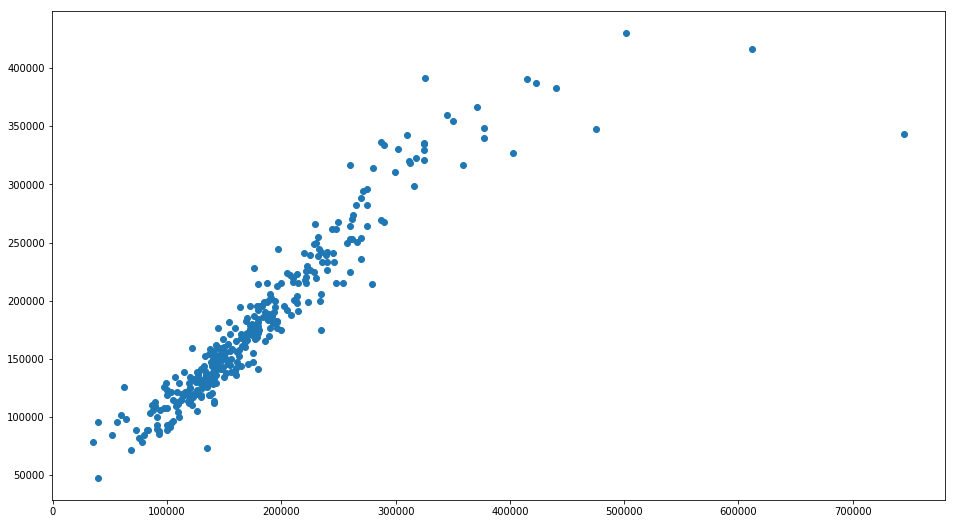

In [119]:
plt.scatter(Y_valid, xgb_model.predict(X_valid, ntree_limit=xgb_model.best_iteration))

# Nets

In [188]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

In [163]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

d:\programs\miniconda3\envs\ai36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
d:\programs\miniconda3\envs\ai36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
d:\programs\miniconda3\envs\ai36\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
d:\programs\miniconda3\envs\ai36\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [233]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.4)))
model.add(BatchNormalization())
model.add(Dense(360, activation='relu', kernel_regularizer=regularizers.l2(0.2)))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [234]:
callbacks = list()
callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0, mode='auto', patience=8))
callbacks.append(ModelCheckpoint('nn.h5', monitor='val_acc', save_weights_only=False,
                                             save_best_only=True, mode='max'))

In [235]:
model.fit(X_train_scaled, Y_train, epochs=200, batch_size=32,  verbose=1, validation_data=(X_valid_scaled, Y_valid), callbacks=callbacks)

Train on 817 samples, validate on 351 samples
Epoch 1/200
817/817 [==============================] - 2s 3ms/step - loss: 38965220353.2534 - mean_squared_error: 38965220353.2534 - val_loss: 38680775116.9459 - val_mean_squared_error: 38680775116.9459
Epoch 2/200
817/817 [==============================] - 0s 169us/step - loss: 38963802006.7173 - mean_squared_error: 38963802006.7173 - val_loss: 38678822608.5926 - val_mean_squared_error: 38678822608.5926
Epoch 3/200
416/817 [==============>...............] - ETA: 0s - loss: 39280064984.6154 - mean_squared_error: 39280064984.6154

d:\programs\miniconda3\envs\ai36\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


817/817 [==============================] - 0s 167us/step - loss: 38961811350.7173 - mean_squared_error: 38961811350.7173 - val_loss: 38676321387.9430 - val_mean_squared_error: 38676321387.9430
Epoch 4/200
817/817 [==============================] - 0s 175us/step - loss: 38958915250.6047 - mean_squared_error: 38958915250.6047 - val_loss: 38673208392.9345 - val_mean_squared_error: 38673208392.9345
Epoch 5/200
817/817 [==============================] - 0s 168us/step - loss: 38954706106.7515 - mean_squared_error: 38954706106.7515 - val_loss: 38668683269.8348 - val_mean_squared_error: 38668683269.8348
Epoch 6/200
817/817 [==============================] - 0s 171us/step - loss: 38948827201.1750 - mean_squared_error: 38948827201.1750 - val_loss: 38662651157.1510 - val_mean_squared_error: 38662651157.1510
Epoch 7/200
817/817 [==============================] - 0s 165us/step - loss: 38941258419.8580 - mean_squared_error: 38941258419.8580 - val_loss: 38650192467.1453 - val_mean_squared_error: 3865

Epoch 43/200
817/817 [==============================] - 0s 163us/step - loss: 35177674328.3623 - mean_squared_error: 35177674328.3623 - val_loss: 35009002831.4986 - val_mean_squared_error: 35009002831.4986
Epoch 44/200
817/817 [==============================] - 0s 154us/step - loss: 34937649327.4712 - mean_squared_error: 34937649327.4712 - val_loss: 34744632276.2393 - val_mean_squared_error: 34744632276.2393
Epoch 45/200
817/817 [==============================] - 0s 154us/step - loss: 34710120723.7405 - mean_squared_error: 34710120723.7405 - val_loss: 34380290555.6239 - val_mean_squared_error: 34380290555.6239
Epoch 46/200
817/817 [==============================] - 0s 159us/step - loss: 34440549011.2705 - mean_squared_error: 34440549011.2705 - val_loss: 34401110185.2080 - val_mean_squared_error: 34401110185.2080
Epoch 47/200
817/817 [==============================] - 0s 149us/step - loss: 34177159198.0808 - mean_squared_error: 34177159198.0808 - val_loss: 34067994151.3846 - val_mean_sq

Epoch 83/200
817/817 [==============================] - 0s 183us/step - loss: 20545666603.2411 - mean_squared_error: 20545666603.2411 - val_loss: 22329766022.1994 - val_mean_squared_error: 22329766022.1994
Epoch 84/200
817/817 [==============================] - 0s 181us/step - loss: 20118875317.7381 - mean_squared_error: 20118875317.7381 - val_loss: 20747071890.5983 - val_mean_squared_error: 20747071890.5983
Epoch 85/200
817/817 [==============================] - 0s 170us/step - loss: 19612640156.9841 - mean_squared_error: 19612640156.9841 - val_loss: 20800543770.2564 - val_mean_squared_error: 20800543770.2564
Epoch 86/200
817/817 [==============================] - 0s 165us/step - loss: 19225021506.4284 - mean_squared_error: 19225021506.4284 - val_loss: 20867777042.9630 - val_mean_squared_error: 20867777042.9630
Epoch 87/200
817/817 [==============================] - 0s 167us/step - loss: 18761130905.2240 - mean_squared_error: 18761130905.2240 - val_loss: 19634819247.0427 - val_mean_sq

Epoch 123/200
817/817 [==============================] - 0s 168us/step - loss: 5473896951.8531 - mean_squared_error: 5473896951.8531 - val_loss: 7458467306.1197 - val_mean_squared_error: 7458467306.1197
Epoch 124/200
817/817 [==============================] - 0s 157us/step - loss: 5315242968.8323 - mean_squared_error: 5315242958.8054 - val_loss: 7800586817.6410 - val_mean_squared_error: 7800586817.6410
Epoch 125/200
817/817 [==============================] - 0s 156us/step - loss: 5020212278.5214 - mean_squared_error: 5020212265.8311 - val_loss: 7971176512.1823 - val_mean_squared_error: 7971176512.1823
Epoch 126/200
817/817 [==============================] - 0s 159us/step - loss: 4840313202.9963 - mean_squared_error: 4840313178.9474 - val_loss: 6619211897.0712 - val_mean_squared_error: 6619211873.7322
Epoch 127/200
817/817 [==============================] - 0s 152us/step - loss: 4430238272.5483 - mean_squared_error: 4430238147.2118 - val_loss: 5711287907.1909 - val_mean_squared_error: 5